In [2]:
# validation_curve : 단일 하이퍼 파라미터 최적화
# GridSearchCV : 그리드를 사용한 복수 하이퍼 파라미터 최적화

import pandas as pd

df = pd.read_csv("c:/data/soccer/player.csv")
df.head()

,id,player_name,birthday,preferred_foot,age,height,weight,potential,right_foot,left_foot,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,overall_rating,Label
0,1,Aaron Appindangoye,1992-02-29,right,27,183,187,71,1,0,...,65,69,69,6,11,10,8,8,67,0
1,2,Aaron Cresswell,1989-12-15,right,30,170,146,71,1,0,...,65,69,69,6,11,10,8,8,67,0
2,3,Aaron Doran,1991-05-13,right,28,170,163,66,1,0,...,65,66,69,6,11,10,8,8,62,0
3,4,Aaron Galindo,1982-05-08,right,37,183,198,65,1,0,...,62,63,66,5,10,9,7,7,61,0
4,5,Aaron Hughes,1979-11-08,right,40,183,154,65,1,0,...,62,63,66,5,10,9,7,7,61,0


In [3]:
train_cols = df.columns[4:43]
print(train_cols)

X = df[train_cols]  # 독립변수
y = df["Label"]  # 종속변수
y.value_counts()

Index(['age', 'height', 'weight', 'potential', 'right_foot', 'left_foot',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')


Label
1    5705
0    5230
Name: count, dtype: int64

In [4]:
# 언더샘플링
from imblearn.under_sampling import RandomUnderSampler

X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample, columns=train_cols)
y_samp = pd.DataFrame(data=y_sample, columns=["Label"])
df_samp = pd.concat([X_samp, y_samp], axis=1)
df_samp.Label.value_counts()

Label
0    5230
1    5230
Name: count, dtype: int64

In [5]:
X = df_samp[train_cols]  # 독립변수
y = df_samp["Label"]  # 종속변수

In [6]:
# validation_curve() : 1개의 파라미터를 튜닝하는 함수
# param_name 최적화할 파라미터 이름
# param_range 범위
# scoring 성능 측정 기준
# 단순한 모형인 경우에는 적합하지만 튜닝할 파라미터가 많은 모형에는 적합하지 않은 방법

from sklearn.model_selection import validation_curve
from sklearn.svm import SVC

param_range = [0.01, 0.1, 1, 10]

train_scores, test_scores = validation_curve(
    SVC(),  # 모델
    X,
    y,
    param_name="C",  # 파라미터(C : cost, 오차에 대한 패널티)
    param_range=param_range,
    cv=2,
    scoring="accuracy",  # 평가 → 정확도
    n_jobs=1,  # cpu core -1 전체
)

In [7]:
print(train_scores)
print(test_scores)

[[0.81491396 0.83518164]
 [0.88489484 0.90210325]
 [0.92810707 0.9418738 ]
 [0.95391969 0.96099426]]
[[0.84225621 0.79407266]
 [0.90095602 0.8709369 ]
 [0.92887189 0.91108987]
 [0.94034417 0.92160612]]


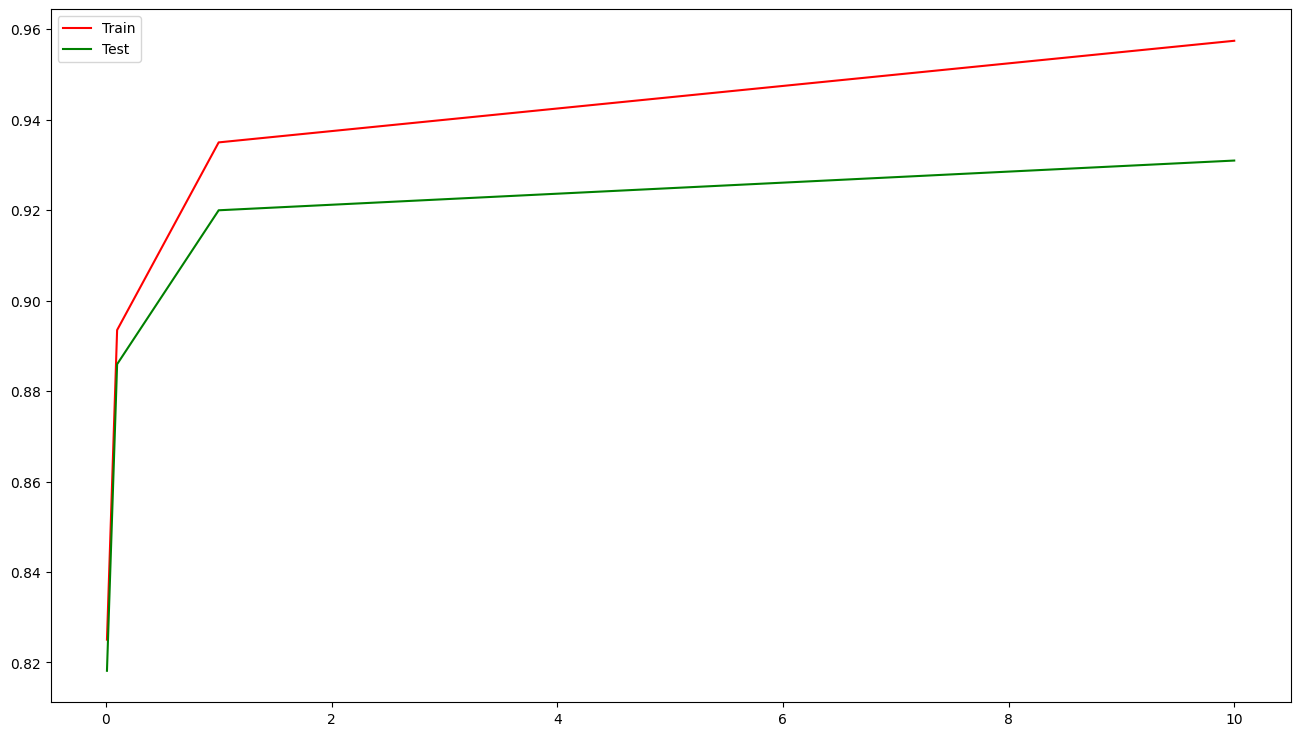

In [8]:
import matplotlib.pyplot as plt
import numpy as np

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.rcParams["figure.figsize"] = (16, 9)
plt.plot(param_range, train_scores_mean, label="Train", color="r")
plt.plot(param_range, test_scores_mean, label="Test", color="g")
plt.legend(loc="best")
plt.show()

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([("scl", StandardScaler()), ("clf", KNeighborsClassifier())])
# 작업순서         전처리 평균0, 표준편자1      분류모형

param_grid = [
    {
        "clf__weights": ["uniform", "distance"],
        # 가중치            균등        차등
        "clf__p": [1, 2],
        #       1유클리드 2맨해튼거리
        "clf__n_neighbors": list(range(2, 6)),
        #       이웃의 수               2~5
    }
]

gs = GridSearchCV(
    estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=3, n_jobs=-1,
    #       분류모형            옵션                   평가      횟수
)
gs.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'clf__n_neighbors': [2, 3, 4, 5], 'clf__p': [1, 2],
                          'clf__weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [10]:
gs.cv_results_["params"]

[{'clf__n_neighbors': 2, 'clf__p': 1, 'clf__weights': 'uniform'},
 {'clf__n_neighbors': 2, 'clf__p': 1, 'clf__weights': 'distance'},
 {'clf__n_neighbors': 2, 'clf__p': 2, 'clf__weights': 'uniform'},
 {'clf__n_neighbors': 2, 'clf__p': 2, 'clf__weights': 'distance'},
 {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'uniform'},
 {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'distance'},
 {'clf__n_neighbors': 3, 'clf__p': 2, 'clf__weights': 'uniform'},
 {'clf__n_neighbors': 3, 'clf__p': 2, 'clf__weights': 'distance'},
 {'clf__n_neighbors': 4, 'clf__p': 1, 'clf__weights': 'uniform'},
 {'clf__n_neighbors': 4, 'clf__p': 1, 'clf__weights': 'distance'},
 {'clf__n_neighbors': 4, 'clf__p': 2, 'clf__weights': 'uniform'},
 {'clf__n_neighbors': 4, 'clf__p': 2, 'clf__weights': 'distance'},
 {'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'uniform'},
 {'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'distance'},
 {'clf__n_neighbors': 5, 'clf__p': 2, 'clf__weights': 'uniform'},
 {'

In [11]:
gs.cv_results_["mean_test_score"]

array([0.85955909, 0.8288693 , 0.86615609, 0.84244523, 0.85353598,
       0.85162376, 0.86338307, 0.86347863, 0.86969312, 0.85162355,
       0.87447335, 0.8627138 , 0.86596455, 0.86405225, 0.87189193,
       0.87131831])

In [12]:
print(gs.best_score_)
print(gs.best_params_)
print(gs.best_estimator_)

0.8744733532844969
{'clf__n_neighbors': 4, 'clf__p': 2, 'clf__weights': 'uniform'}
Pipeline(steps=[('scl', StandardScaler()),
                ('clf', KNeighborsClassifier(n_neighbors=4))])


In [13]:
from sklearn.model_selection import cross_val_score

p = Pipeline(
    [
        ("scl", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=4, p=2, weights="uniform")),
    ]
)
result = cross_val_score(p, X, y, cv=10)

# 교차검증 결과
print(result)

# 교차검증 평균값
print(np.mean(result))

# 교차검증 최대값
print(np.max(result))

[0.83556405 0.92734226 0.86998088 0.90057361 0.90344168 0.85181644
 0.85372849 0.87858509 0.86806883 0.87380497]
0.8762906309751435
0.9273422562141491
